In [59]:
# Cell 1 — Install Darts
!pip install darts

In [60]:
# Cell 2 — Imports
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.utils.likelihood_models import GaussianLikelihood
from sklearn.metrics import mean_squared_error
import torch

In [61]:
# Cell 3 — Load your daily data (imputed & aggregated)
# Make sure this file contains at least: dt, third_category_id, daily_sale_imputed
df = pd.read_parquet("/kaggle/input/freshretailnet-50k-daily-imputed/daily_df_imputed.parquet")
df['dt'] = pd.to_datetime(df['dt'])
print("Loaded daily DF:", df.shape)
df.head()

Loaded daily DF: (4500000, 17)


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,daily_sale_imputed,oos_hours_total,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
0,0,0,0,5,6,65,38,2024-03-28,0.100000,0,1.0,0,0,1.6999,15.48,73.54,1.97
1,0,0,0,5,6,65,38,2024-03-29,0.114286,3,1.0,0,0,3.0190,15.08,76.56,1.71
2,0,0,0,5,6,65,38,2024-03-30,0.000000,6,1.0,1,0,2.0942,15.91,76.47,1.73
3,0,0,0,5,6,65,38,2024-03-31,0.218182,13,1.0,1,0,1.5618,16.13,77.40,1.76
4,0,0,0,5,6,65,38,2024-04-01,0.533333,15,1.0,0,0,3.5386,15.37,78.26,1.25


Aggregated category 65, series length: 90


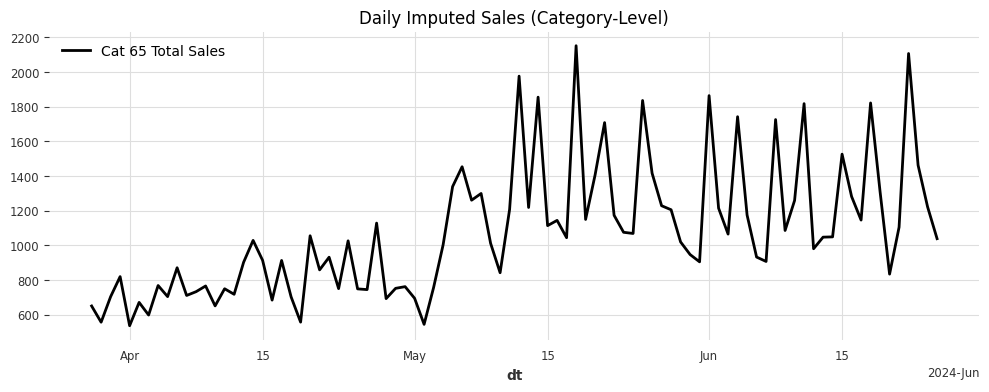

In [62]:


cat_id = 65
df_cat = df[df['third_category_id']==cat_id].sort_values('dt')

# sum imputed sales across all store–products per day
df_cat_agg = (
    df_cat
    .groupby('dt', as_index=False)['daily_sale_imputed']
    .sum()
)

series = TimeSeries.from_dataframe(
    df_cat_agg,
    time_col='dt',
    value_cols='daily_sale_imputed',
    fill_missing_dates=True,
    freq='D'
)
raw_vals   = series.values()             # shape (n_points, 1)
log_vals   = np.log1p(raw_vals)          # same shape
log_series = TimeSeries(series.time_index, log_vals)

print(f"Aggregated category {cat_id}, series length:", len(series))

plt.figure(figsize=(12,4))
series.plot(label=f"Cat {cat_id} Total Sales")
plt.title("Daily Imputed Sales (Category-Level)")
plt.show()

Category 17 — raw series length: 90


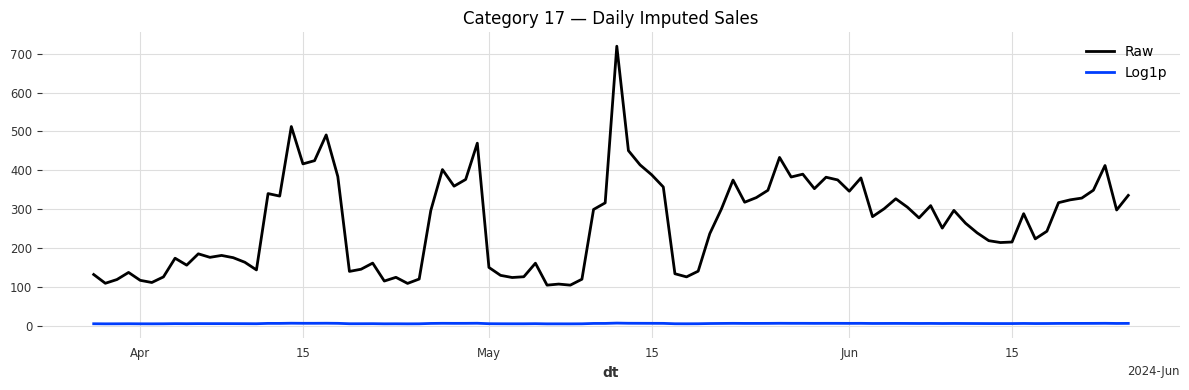

Category 65 — raw series length: 90


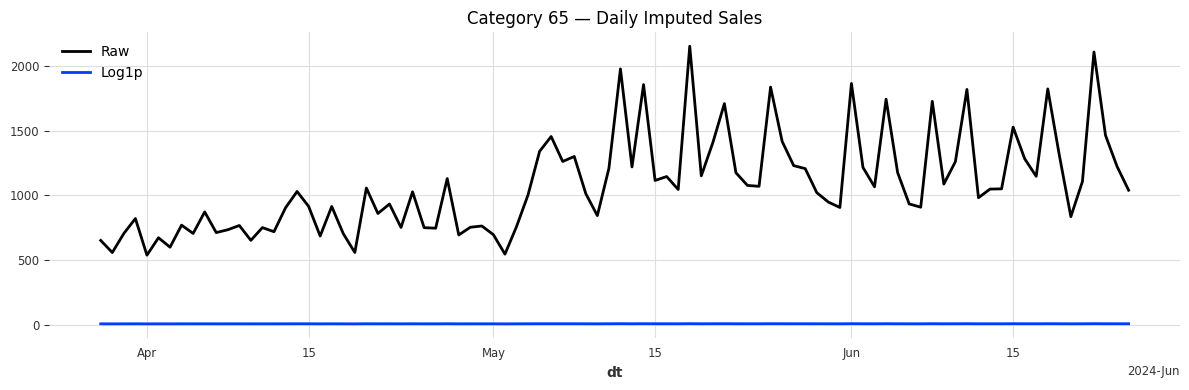

Category 81 — raw series length: 90


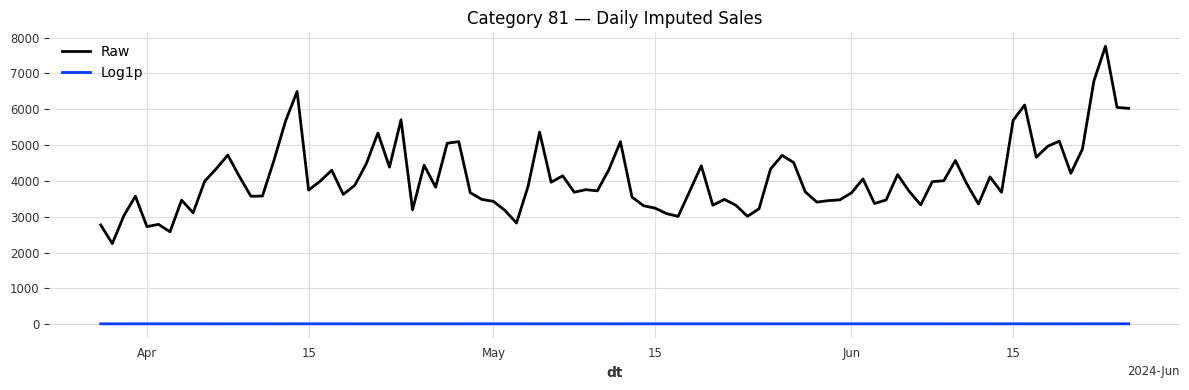

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries

# list of categories to process
cat_ids = [17, 65, 81]

for cat_id in cat_ids:
    # 1️⃣ filter & aggregate at the category-day level
    df_cat = df[df['third_category_id'] == cat_id].sort_values('dt')
    df_cat_agg = (
        df_cat
        .groupby('dt', as_index=False)['daily_sale_imputed']
        .sum()
    )
    # 2️⃣ build a Darts TimeSeries, filling any missing dates
    series = TimeSeries.from_dataframe(
        df_cat_agg,
        time_col='dt',
        value_cols='daily_sale_imputed',
        fill_missing_dates=True,
        freq='D'
    )
    # 3️⃣ also keep a log1p‐transformed version
    log_series = TimeSeries(
        series.time_index,
        np.log1p(series.values())
    )
    print(f"Category {cat_id} — raw series length: {len(series)}")

    # 4️⃣ plot
    plt.figure(figsize=(12, 4))
    series.plot(label='Raw')
    log_series.plot(label='Log1p')
    plt.title(f"Category {cat_id} — Daily Imputed Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [64]:
# Cell: Train/Test Split
train, val = log_series.split_after(0.8)  # 80% train, 20% val


# Cell: Instantiate & Fit N-BEATS
from darts.models import NBEATSModel
from sklearn.metrics import mean_squared_error

model = NBEATSModel(
    input_chunk_length=28,     # look back 28 days
    output_chunk_length=7,     # forecast 7 days ahead
    n_epochs=50,               # number of training epochs
    dropout=0.1,               # dropout in each layer
    batch_size=8,             # minibatch size
    random_state=42,           # reproducibility
    add_encoders={
        # cyclical encoding for day-of-week
        "cyclic": {
            "past":   ["dayofweek"],
            "future": ["dayofweek"],
        },
        # numeric month-of-year encoding
        "datetime_attribute": {
            "past":   ["month"],
            "future": ["month"],
        }
    },
    pl_trainer_kwargs={        # pass through to PyTorch Lightning
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "devices": 1,
    }
)

model.fit(train, verbose=True)


Training: |          | 0/? [00:00<?, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1, activation=ReLU, input_chunk_length=28, output_chunk_length=7, n_epochs=50, batch_size=8, random_state=42, add_encoders={'cyclic': {'past': ['dayofweek'], 'future': ['dayofweek']}, 'datetime_attribute': {'past': ['month'], 'future': ['month']}}, pl_trainer_kwargs={'accelerator': 'cpu', 'devices': 1})

Predicting: |          | 0/? [00:00<?, ?it/s]

Validation MAE: 1582.44


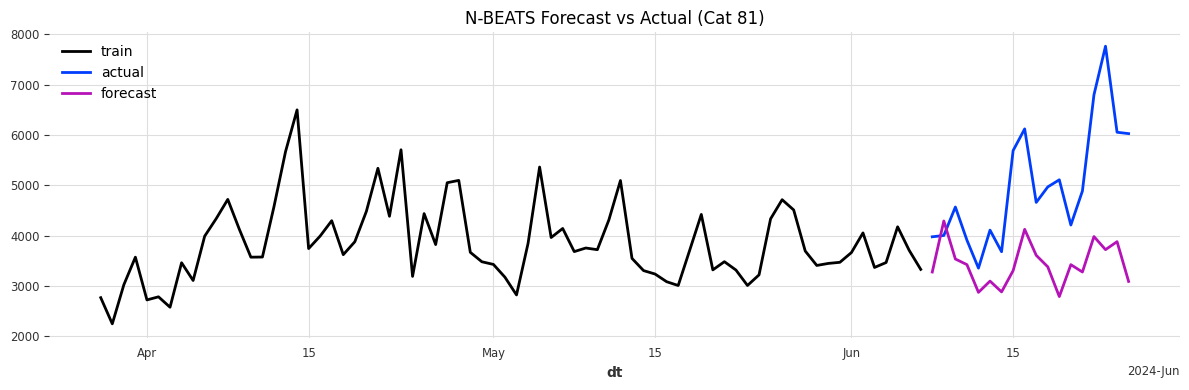

In [65]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# predict
pred_log = model.predict(len(val), series=train, past_covariates=None)

raw_preds   = pred_log.values()             # shape (n_points, 1)
log_preds   = np.expm1(raw_preds)          # same shape
pred = TimeSeries(pred_log.time_index, log_preds)

# pred = pred_log.transform(np.expm1)

actual = series.slice_intersect(pred)
mae  = mean_absolute_error(actual.values(), pred.values())
print(f"Validation MAE: {mae:.2f}")

raw_train   = train.values()             # shape (n_points, 1)
log_train   = np.expm1(raw_train)          # same shape
train = TimeSeries(train.time_index, log_train)

raw_val   = val.values()             # shape (n_points, 1)
log_val   = np.expm1(raw_val)          # same shape
val = TimeSeries(val.time_index, log_val)


# plot
plt.figure(figsize=(12,4))
train.plot(label='train')
val.plot(label='actual')
pred.plot(label='forecast')
plt.title(f"N-BEATS Forecast vs Actual (Cat {cat_id})")
plt.legend()
plt.tight_layout()
plt.show()